In [999]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import random

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')

In [1000]:
display(students.sample(10))
students.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
48,GP,M,15,U,GT3,T,4.0,2.0,teacher,other,home,mother,1.0,2.0,NaN,no,yes,yes,no,yes,-6.0,NaN,no,no,4.0,3.0,3.0,5.0,2.0,70.0
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,reputation,NaN,1.0,1.0,0.0,no,NaN,no,yes,no,-3.0,yes,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0
237,GP,F,16,U,NaN,T,2.0,1.0,other,other,home,mother,1.0,1.0,0.0,no,NaN,no,no,yes,-3.0,yes,yes,yes,4.0,5.0,2.0,5.0,20.0,60.0
221,GP,F,17,U,NaN,T,1.0,1.0,at_home,other,reputation,mother,1.0,3.0,1.0,no,yes,no,yes,yes,-9.0,yes,no,yes,4.0,3.0,NaN,5.0,0.0,0.0
286,GP,F,18,U,GT3,T,2.0,NaN,at_home,at_home,other,mother,1.0,3.0,0.0,no,yes,yes,no,yes,-9.0,yes,yes,no,4.0,3.0,3.0,2.0,5.0,95.0
114,GP,M,15,R,NaN,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,-6.0,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0
351,MS,M,17,U,GT3,T,3.0,3.0,health,other,course,mother,2.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,4.0,5.0,4.0,3.0,2.0,65.0
63,GP,F,16,U,GT3,NaN,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,-9.0,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0
335,GP,F,17,U,GT3,T,3.0,4.0,services,other,NaN,mother,1.0,3.0,0.0,no,NaN,no,no,yes,-9.0,yes,yes,no,4.0,4.0,5.0,5.0,16.0,75.0
30,GP,M,15,U,GT3,T,4.0,4.0,health,services,home,mother,NaN,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,4.0,2.0,NaN,0.0,60.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [1001]:
def drop_empty(df, row):
    df[row] = df[row].astype(str).apply(lambda x: None if x.strip() == '' else x)
    return df[df[row] != "nan"]


def fill_empty_random(df, row):
    values = random.choices(df[row].value_counts().index, df[row].value_counts().values, 
                                                          k= np.size(np.where(pd.isnull(df[row]))))
    
    empty = np.where(pd.isnull(df[row]))
 
    pares = {}
    for a,b in zip(empty[0], values):
        pares[a] = b
      
    df[row].fillna(value=pares, inplace=True)
    return df

def replace_fail_with_nan(df, row, allowed):
    df[row] = df[row].apply(lambda x: x if x in allowed else np.nan)
    return df

## Pre-process columns with nominative and ordinal variables with known specification first


In [1024]:
nom_categories = { "sex" : ["F", "M"],
                   "address": ["U", "R"],
                   "famsize" : [ "LE3", "GT3"],
                   "Pstatus" : ["T", "A"],
                   "Medu" : [0, 1, 2, 3, 4],
                   "Fedu" : [0, 1, 2, 3, 4],
                   "Mjob": ['teacher', 'health', 'services', 'at_home', 'other'],
                   "Fjob" : ['teacher', 'health', 'services', 'at_home', 'other'],
                   "reason" : ['home', 'reputation', 'course', 'other'],
                   "guardian" : ["mother", "father", "other"],
                   "traveltime" : [1, 2, 3, 4],
                   "studytime" : [1, 2, 3, 4],
                   "failures" : [0, 1, 2, 3],
                   "schoolsup" : ["yes", "no"],
                   "famsup" : ["yes", "no"],
                   "paid" : ["yes", "no"],
                   "activities" : [ "yes", "no"],
                   "nursery" : [ "yes", "no" ],
                   "higher" : ["yes", "no"],
                   "internet" : ["yes", "no"],
                   "romantic" : ["yes", "no"],
                   "famrel" : [1, 2, 3, 4, 5],
                   "freetime" : [1, 2, 3, 4, 5],
                   "goout" : [1, 2, 3, 4, 5],
                   "health" : [1, 2, 3, 4, 5],
                  }

for row in nom_categories:
    printmd(f"### {row}")
    display(students[row].value_counts(dropna=False))
    replace_empty = False
    
    if np.nan in students[row].value_counts(dropna=False).index:
        printmd(f"#### Missing values: {students[row].value_counts(dropna=False).loc[np.nan]}")
        replace_empty = True
    else:
        printmd(f"#### No Missing values")
        
    unexpected_val = set(students[row].dropna().unique()) - set(nom_categories[row])
    
    if unexpected_val:
        printmd(f"#### Unexpected values found: {unexpected_val}")
        #At first replace with NaN to prepare for the next step
        students = replace_fail_with_nan(students, "Fedu", [0,1,2,3,4])
        replace_empty = True
    else:
        printmd(f"#### No Unexpected values discovered")
        
    if replace_empty:
        #Filling missing data by randomly selected valid values with same frequency as in remaining part of the sample:
        students = fill_empty_random(students, row)
   
    printmd("**--------------------------------------------------------**")

### sex

F    208
M    187
Name: sex, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### address

U    308
R     87
Name: address, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### famsize

GT3    283
LE3    112
Name: famsize, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### Pstatus

T    353
A     42
Name: Pstatus, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### Medu

4.0    132
2.0    103
3.0     97
1.0     60
0.0      3
Name: Medu, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### Fedu

2.0    116
3.0    102
4.0     91
1.0     84
0.0      2
Name: Fedu, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### Mjob

other       144
services    101
at_home      61
teacher      57
health       32
Name: Mjob, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### Fjob

other       212
services    119
teacher      31
at_home      17
health       16
Name: Fjob, dtype: int64

#### No Missing values

#### No Unexpected values discovered

**--------------------------------------------------------**

### reason

course        137
home          104
reputation    103
other          34
NaN            17
Name: reason, dtype: int64

#### Missing values: 17

#### No Unexpected values discovered

**--------------------------------------------------------**

### guardian

mother    250
father     86
NaN        31
other      28
Name: guardian, dtype: int64

#### Missing values: 31

#### No Unexpected values discovered

**--------------------------------------------------------**

### traveltime

1.0    242
2.0     96
NaN     28
3.0     22
4.0      7
Name: traveltime, dtype: int64

#### Missing values: 28

#### No Unexpected values discovered

**--------------------------------------------------------**

### studytime

2.0    194
1.0    103
3.0     64
4.0     27
NaN      7
Name: studytime, dtype: int64

#### Missing values: 7

#### No Unexpected values discovered

**--------------------------------------------------------**

### failures

0.0    293
1.0     49
NaN     22
2.0     16
3.0     15
Name: failures, dtype: int64

#### Missing values: 22

#### No Unexpected values discovered

**--------------------------------------------------------**

### schoolsup

no     335
yes     51
NaN      9
Name: schoolsup, dtype: int64

#### Missing values: 9

#### No Unexpected values discovered

**--------------------------------------------------------**

### famsup

yes    219
no     137
NaN     39
Name: famsup, dtype: int64

#### Missing values: 39

#### No Unexpected values discovered

**--------------------------------------------------------**

### paid

no     200
yes    155
NaN     40
Name: paid, dtype: int64

#### Missing values: 40

#### No Unexpected values discovered

**--------------------------------------------------------**

### activities

yes    195
no     186
NaN     14
Name: activities, dtype: int64

#### Missing values: 14

#### No Unexpected values discovered

**--------------------------------------------------------**

### nursery

yes    300
no      79
NaN     16
Name: nursery, dtype: int64

#### Missing values: 16

#### No Unexpected values discovered

**--------------------------------------------------------**

### higher

yes    356
NaN     20
no      19
Name: higher, dtype: int64

#### Missing values: 20

#### No Unexpected values discovered

**--------------------------------------------------------**

### internet

yes    305
no      56
NaN     34
Name: internet, dtype: int64

#### Missing values: 34

#### No Unexpected values discovered

**--------------------------------------------------------**

### romantic

no     240
yes    124
NaN     31
Name: romantic, dtype: int64

#### Missing values: 31

#### No Unexpected values discovered

**--------------------------------------------------------**

### famrel

 4.0    182
 5.0     99
 3.0     62
 NaN     27
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

#### Missing values: 27

#### Unexpected values found: {-1.0}

**--------------------------------------------------------**

### freetime

3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
NaN     11
Name: freetime, dtype: int64

#### Missing values: 11

#### No Unexpected values discovered

**--------------------------------------------------------**

### goout

3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
NaN      8
Name: goout, dtype: int64

#### Missing values: 8

#### No Unexpected values discovered

**--------------------------------------------------------**

### health

5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
NaN     15
Name: health, dtype: int64

#### Missing values: 15

#### No Unexpected values discovered

**--------------------------------------------------------**

## Check columns with nominative and ordinal variables with unknown specification or missing description

### School

In [1025]:
students.school.value_counts()

GP    349
MS     46
Name: school, dtype: int64

**No unexpected values discovered, no missing values**

### studytime, granular

In [1026]:
students['studytime, granular'].value_counts(dropna=False)

-6.0     194
-3.0     103
-9.0      64
-12.0     27
 NaN       7
Name: studytime, granular, dtype: int64

<AxesSubplot:title={'center':'Father education period'}>

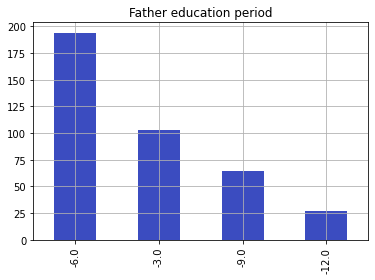

In [1027]:
students['studytime, granular'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Father education period')

**Some values are missing, looks like interval variable, missing values potentially fillable like other nominative variables for this data set with fill_empty_random() function, but will not do this for now**

## Check columns with numerical variables

### age

In [1037]:
students.loc[:,["age"]].describe()

,age
count,389.000000
mean,16.673522
std,1.265662
min,15.000000
25%,16.000000
50%,17.000000
75%,18.000000
max,22.000000


<AxesSubplot:>

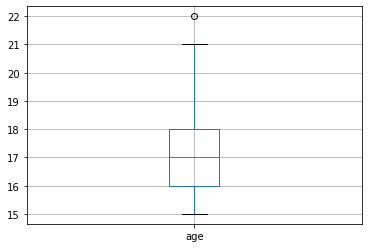

In [1035]:
students.boxplot(column=['age'])

<AxesSubplot:title={'center':'Students by age'}>

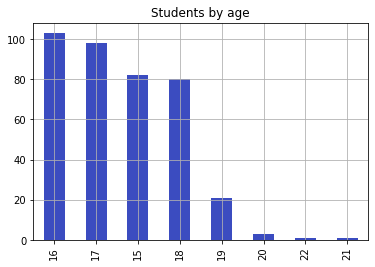

In [1033]:
students['age'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Students by age')

## Finally drop some data

### Drop rows where taget value is not specified:


In [1029]:
display(students.score.value_counts(dropna=False))

students = drop_empty(students, "score")



50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
45.0     27
70.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
NaN       6
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

### Drop outlayers